# Causal Explanations in Models with Continuous Random Variables

The **Explainable Reasoning with Chirho** package aims to provide a unified, principled approach to computations of causal explanations. We showed in an earlier [tutorial](https://basisresearch.github.io/chirho/explainable_categorical.html) how Chirho provides a handler `SearchForExplanation` to carry out the program transformations needed to compute causal queries and explanations, focusing on discrete variables (we assume the reader is familar with it). In this notebook we illustrate the usage of `SearchForExplanation` for causal models with continuous random variables in the context of a dynamical system.

We take an epidemiological dynamical system model (described in more detail in this [tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html)) and show how the but-for analysis is not sufficiently fine-grained to allow us to derive the right conclusions about the effects of different policies during a pandemic. Next, we illustrate how various causal explanation queries can be computed using `SearchForExplanation` and inference algorithms. We also demonstrate how more detailed causal queries can be answered by post-processing the samples obtained using the handler. 

## Outline

- [Setup](#setup)
- [Bayesian Epidemiological SIR Model with Policies](#bayesian-epidemiological-sir-model-with-policies)
    - [SIR Model and Simulation](#sir-model-and-simulation)
    - [Bayesian SIR Model](#bayesian-sir-model)
    - [Bayesian SIR Model with Policies](#bayesian-sir-model-with-policies)
- [But for Analysis with Bayesian SIR Model with Policies](#but-for-analysis-with-bayesian-sir-model-with-policies)
- [Causal Explanations using `SearchForExplanation`](#causal-explanations-using-searchforexplanation)
- [Fine-grained Analysis of `overshoot` using Sample traces](#fine-grained-analysis-of-overshoot-using-sample-traces)
- [For Advanced Readers: Looking into Different Contexts](#ooking-into-different-contexts-for-curious-readers)

## Setup


The main dependencies for this example are PyTorch, Pyro, and ChiRho.


In [14]:
import numbers
import os
from typing import Tuple, TypeVar, Union, Optional, Callable
import math

import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
from pyro.distributions import constraints
import seaborn as sns
import torch
from pyro.infer import Predictive

import pyro
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.dynamical.handlers.interruption import StaticEvent
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.ops import Dynamics, State, on, simulate
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.ops import Intervention, intervene
from chirho.observational.handlers import condition

R = Union[numbers.Real, torch.Tensor]
S = TypeVar("S")
T = TypeVar("T")


sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_samples = 10 if smoke_test else 10000

## Bayesian Epidemiological SIR model with Policies


We start with building the epidemiological SIR (Susceptible, Infected, Recovered/Removed) model, one step at a time. We first encode the deterministic SIR dynamics. Then we add uncertainty about the parameters that govern these dynamics - $\beta$ and $\gamma$. These parameters have been described in much detail in the [dynamical systems tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html). We then incorporate the resulting model into a more complex causal model that involves two policy mechanisms: imposing lockdown and masking restrictions.

Our outcome of interest is overshoot, the proportion of the population that remains susceptible after the epidemic peak but eventually becomes infected as the epidemic continues. One way to compute it is to:

1. Find the time at which the number of infected individuals is at its peak, `t_max`.
2. Determine the proportion of susceptibles at `t_max` in the whole population, `S_peak`.
3. Find the proportion of susceptibles (those who have never been infected yet) at the end of the logging period, `S_final`.
4. Calculate the additional ratio of infected or infected and later removed individuals since the peak as `S_peak - S_final`.

This quantity is of interest because epidemic mitigation policies often have multiple goals that need to be balanced. One goal is to increase `S_final`, i.e., to limit the total number of infected individuals. Another goal is to limit the number of infected individuals at the peak of the epidemic to avoid overwhelming the healthcare system. A further goal is to minimize the proportion of the population that becomes infected after the peak, that is, the overshoot, to reduce healthcare and economic burdens. Balancing these objectives involves making trade-offs.

 Suppose we are working under constraint that the overshoot should be lower than 24% of the population, and we implement two policies, lockdown and masking, which together seem to lead to the overshoot being too high. In fact, only one of them is responsible, and we are interested in being able to identify which one. 

### SIR Model and Simulation

In [15]:
# dS = - beta . SI
# dI = beta * SI - gamma * I
# dR = gamma * I


class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX: State[torch.Tensor] = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

        return dX


# l is a parameter describing the strenght of the intervening policies
# it is a value between 0 and 1, and (1-l) is the fraction of the original unintervened beta
class SIRDynamicsPolicies(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])
        return dX

In [16]:
# Computing overshoot in a simple SIR model without interventions
# note it's below the desired threshold

init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(12.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)
init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

# We now simulate from the SIR model
beta_true = torch.tensor([0.03])
gamma_true = torch.tensor([0.5])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory


def get_overshoot(trajectory):
    t_max = torch.argmax(trajectory["I"].squeeze())
    S_peak = torch.max(trajectory["S"].squeeze()[t_max]) / 100
    S_final = trajectory["S"].squeeze()[-1] / 100
    return (S_peak - S_final).item()


print(get_overshoot(sir_true_traj))

0.15116800367832184


The number $0.15$ is the overshoot you get if $\beta = 0.03, \gamma = 0.5$. This value is observed by simulating the SIR dynamics model with these values and calculating the overshoot directly.

Also, note that the above dynamical system introduces the variables: `S` - susceptible, `I` - infected, `R` - recovered and `l` - effect of intervention. These variables evolve over time and their dynamics are captured by the model. As we add features to our model, we also add new variables to this list. Further on in the notebook, we will describe the probabilities we compute in terms of these variables.

### Bayesian SIR model



Now suppose we are uncertain about $\beta$ and $\gamma$, and want to construct a Bayesian SIR model that incorporates this uncertainty. Say we induce $\beta$ to be drawn from the distribution `Beta(18, 600)`, and $\gamma$ to be drawn from distribution `Beta(1600, 1600)`. This converts the parameters of the original dynamical system into random variables `beta` and `gamma` in our model.

In [17]:
# Defining a Bayesian SIR model where we have priors over beta and gamma distributions

def bayesian_sir(base_model=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Beta(18, 600))
    gamma = pyro.sample("gamma", dist.Beta(1600, 1600))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics
) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

### Bayesian SIR model with Policies



Now we incorporate the Bayesian SIR model into a larger model that includes the effect of two different policies, lockdown and masking, where each can be implemented with $50\%$ probability (these probabilities won't really matter, as we will be intervening on these, the sampling is mainly used to register the parameters with Pyro). We encode their efficiencies which further affect the model. Crucially, these efficiencies interact in a fashion resembling the structure of the stone-throwing example we discussed in the tutorial on categorical variables. If lockdown is present, this limits the impact of masking as agents interact less and so masks have fewer opportunities to block anything. We assume the situation is asymmetric: masking has no impact on the efficiency of lockdown. The model also computes `overshoot` and `os_too_high` for further analysis.



In [18]:
# a utility function
# allowing for interventions on a dynamical system
# within another model

def MaskedStaticIntervention(time: R, intervention: Intervention[State[T]]):

    @on(StaticEvent(time))
    def callback(
        dynamics: Dynamics[T], state: State[T]
    ) -> Tuple[Dynamics[T], State[T]]:

        with pyro.poutine.block():
            return dynamics, intervene(state, intervention)

    return callback

In [19]:
# Defining the policy model

overshoot_threshold = 24
lockdown_time = torch.tensor(1.0)
mask_time = torch.tensor(1.5)

def policy_model():

    lockdown = pyro.sample("lockdown", dist.Bernoulli(torch.tensor(0.5)))
    mask = pyro.sample("mask", dist.Bernoulli(torch.tensor(0.5)))

    lockdown_efficiency = pyro.deterministic(
        "lockdown_efficiency", torch.tensor(0.6) * lockdown, event_dim=0
    )

    mask_efficiency = pyro.deterministic(
        "mask_efficiency", (0.1 * lockdown + 0.45 * (1 - lockdown)) * mask, event_dim=0
    )

    joint_efficiency = pyro.deterministic(
        "joint_efficiency",
        torch.clamp(lockdown_efficiency + mask_efficiency, 0, 0.95),
        event_dim=0,
    )

    lockdown_sir = bayesian_sir(SIRDynamicsPolicies)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MaskedStaticIntervention(lockdown_time, dict(l=lockdown_efficiency)):
                with MaskedStaticIntervention(mask_time, dict(l=joint_efficiency)):
                    simulate(
                        lockdown_sir, init_state_lockdown, start_time, logging_times[-1]
                    )

    trajectory = lt.trajectory

    t_max = torch.max(trajectory["I"], dim=-1).indices
    S_peaks = pyro.ops.indexing.Vindex(trajectory["S"])[..., t_max]
    overshoot = pyro.deterministic(
        "overshoot", S_peaks - trajectory["S"][..., -1], event_dim=0
    )
    os_too_high = pyro.deterministic(
        "os_too_high",
        (overshoot > overshoot_threshold).clone().detach().float(),
        event_dim=0,
    )

    return overshoot, os_too_high

Now that we have our full-fledged model of SIR dynamics along with interventions, we have a complete list of random variables in question. In our explanation we will abbreviate them as follows. `S` - susceptible, `I` - infected, `R` - recovered, `l` - the effect of intervention, `beta`, `gamma` - the parameters of the SIR dynamics model, `ld` - lockdown, `m` - masking, `le` - lockdown efficiency, `me` - mask efficiency, `je` - joint efficiency, `os` - overshoot, and `oth` - overshoot is too high. We use these notations in the rest of the notebook to describe the probabilities we are computing.

## But for Analysis with Bayesian SIR model with Policies


Suppose now we introduced both policies, and this resulted in an overshoot. What intuitively is the case is that lockdown limited the efficiency of masking, and it was in fact the lockdown that in this particular context caused the overshoot (this is consistent with saying that in the context where only masking has been implemented, masking would be responsible for the resulting overshoot being too high).

We might try to use the but-for analysis to idenitfy which of the policies causes overshoot to be too high. To do so, we investigate the following four scenarios:

1. None of the policies were applied
2. Both lockdown and masking were enforced
3. Only masking was imposed
4. Only lockdown was imposed

The hope is that by looking at these we will be able to indentify the culprit. We create these four models by conditioning on the policies being imposed as required (in fact, this has the same effect as intervening here, as the sites are upstream from the dynamical system model; we could emulate 1-4 using `do` with the same estimates). For the sake of completeness, we also illustrate the consequences of following a stochastic policy and deciding randomly about the interventions.

In [20]:
# conditioning (as opposed to intervening) is sufficient for
# propagating the changes, as the decisions are upstream from ds

# no interventions
policy_model_none = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
)
unintervened_predictive = Predictive(
    policy_model_none, num_samples=num_samples, parallel=True
)
unintervened_samples = unintervened_predictive()

# both interventions
policy_model_all = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
)
intervened_predictive = Predictive(
    policy_model_all, num_samples=num_samples, parallel=True
)
intervened_samples = intervened_predictive()

policy_model_mask = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(1.0)}
)
mask_predictive = Predictive(policy_model_mask, num_samples=num_samples, parallel=True)
mask_samples = mask_predictive()

policy_model_lockdown = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(0.0)}
)
lockdown_predictive = Predictive(
    policy_model_lockdown, num_samples=num_samples, parallel=True
)
lockdown_samples = lockdown_predictive()

predictive = Predictive(policy_model, num_samples=num_samples, parallel=True)
samples = predictive()

print("Variables in the model:", samples.keys())

Variables in the model: dict_keys(['lockdown', 'mask', 'beta', 'gamma', 'lockdown_efficiency', 'mask_efficiency', 'joint_efficiency', 'S', 'I', 'R', 'l', 'overshoot', 'os_too_high'])


Note that the above list of variables match our list of variables earlier when we constructed the full-fledged SIR model.

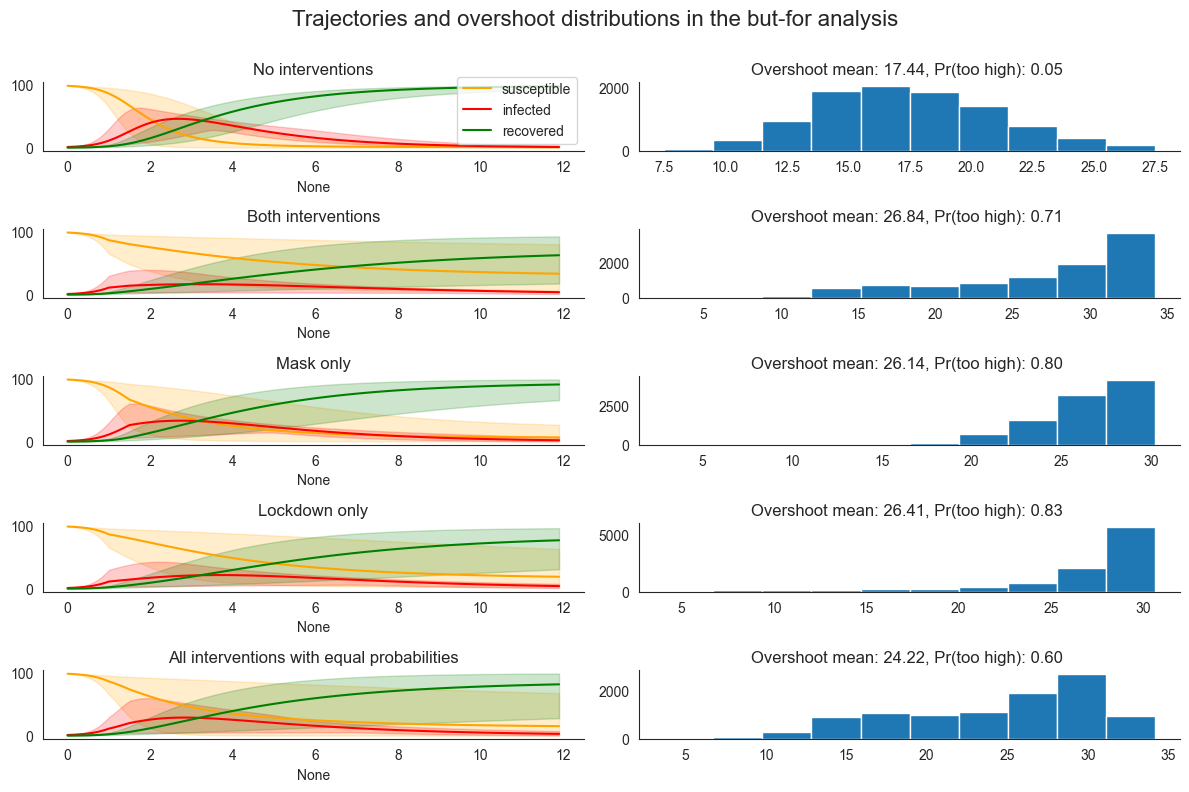

In [21]:
def add_pred_to_plot(preds, axs, coords, color, label):
    sns.lineplot(
        x=logging_times,
        y=preds.mean(dim=0).squeeze().tolist(),
        ax=axs[coords],
        label=label,
        color=color,
    )
    axs[coords].fill_between(
        logging_times,
        torch.quantile(preds, 0.025, dim=0).squeeze(),
        torch.quantile(preds, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
    )


fig, axs = plt.subplots(5, 2, figsize=(12, 7.5))

colors = ["orange", "red", "green"]

add_pred_to_plot(
    unintervened_samples["S"], axs, coords=(0, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    unintervened_samples["I"], axs, coords=(0, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    unintervened_samples["R"], axs, coords=(0, 0), color=colors[2], label="recovered"
)

axs[0, 1].hist(unintervened_samples["overshoot"].squeeze())
axs[0, 0].set_title("No interventions")
axs[0, 1].set_title(
    f"Overshoot mean: {unintervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {unintervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    intervened_samples["S"], axs, coords=(1, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    intervened_samples["I"], axs, coords=(1, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    intervened_samples["R"], axs, coords=(1, 0), color=colors[2], label="recovered"
)
axs[1, 0].set_title("Both interventions")
axs[1, 0].legend_.remove()


axs[1, 1].hist(intervened_samples["overshoot"].squeeze())
axs[1, 1].set_title(
    f"Overshoot mean: {intervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {intervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    mask_samples["S"], axs, coords=(2, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    mask_samples["I"], axs, coords=(2, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    mask_samples["R"], axs, coords=(2, 0), color=colors[2], label="recovered"
)
axs[2, 0].set_title("Mask only")
axs[2, 0].legend_.remove()

axs[2, 1].hist(mask_samples["overshoot"].squeeze())
axs[2, 1].set_title(
    f"Overshoot mean: {mask_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {mask_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    lockdown_samples["S"], axs, coords=(3, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    lockdown_samples["I"], axs, coords=(3, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    lockdown_samples["R"], axs, coords=(3, 0), color=colors[2], label="recovered"
)
axs[3, 0].set_title("Lockdown only")
axs[3, 0].legend_.remove()

axs[3, 1].hist(lockdown_samples["overshoot"].squeeze())
axs[3, 1].set_title(
    f"Overshoot mean: {lockdown_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {lockdown_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(samples["S"], axs, coords=(4, 0), color=colors[0], label="susceptible")
add_pred_to_plot(samples["I"], axs, coords=(4, 0), color=colors[1], label="infected")
add_pred_to_plot(samples["R"], axs, coords=(4, 0), color=colors[2], label="recovered")
axs[4, 0].set_title("All interventions with equal probabilities")
axs[4, 0].legend_.remove()

axs[4, 1].hist(samples["overshoot"].squeeze())
axs[4, 1].set_title(
    f"Overshoot mean: {samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


fig.tight_layout()
fig.suptitle(
    "Trajectories and overshoot distributions in the but-for analysis",
    fontsize=16,
    y=1.05,
)
sns.despine()

# plt.savefig("counterfactual_sir.png")

The plots above show what happens in different scenarios. We observe that in the model where none of the policies were imposed, the probability of the overshoot being too high is relatively low, $\approx 0.05$. On the other hand, when both policies were imposed, the probability of the overshoot being to high was relatively high at $\approx 0.7$. 

To identify which of `lockdown` and `mask` is the cause, we analyze the models where only one of the policies were imposed. Interestingly, the effect of the interventions is somewhat nuanced. Implementing both interventions increases the risk of overshoot as compared to the no intervention model, but individual interventions would have even worse consequences, which means that the two interventions while jointly increasing the risk to some extent mitigate each other's contribution to that risk as well.

Crucially, the analysis does not allow us to distinghuish the intuitive role that the lockdown played, as opposed to masking (whose impact has been limited by the presence of lockdown). So, we need a more fine-grained analysis where we not only control the variables being intervened on (that is, the policies), but also pay attention to what context we are in. We achieve that level of sensitivity by stochastically keeping part of the context (that is, other variables in the model) fixed (see the tutorial for categorical variables for a more extensive explanation of this method and simpler examples). The key idea is that starting with the scenario in which both interventions have been implemented, there is a context such that if we keep it fixed, removing lockdown would significantly lower the overshoot, but there is no context that we could keep fixed such that if in that context we remove the masking policy, the overshoot would decrease. In the next section, we show how this analysis can be carried out with the help of `SearchForExplanation`.

## Causal Explanations using SearchForExplanation


Before we dive into the code below, let us first define some notation. We use small case abbreviations to refer to the value of the variables under consideration. For example, $\mathit{ld}$ refers to `lockdown=1` and $\mathit{ld}'$ refers to `lockdown=0`. We place interventions in the subscripts, i.e. $\mathit{os}_{\mathit{ld}}$ refers to the `overshoot` under the intervention that `lockdown=1`. Later on in the notebook, we also employ contexts that are kept fixed in the intervened worlds. We place these contexts in the superscript. For example, $\mathit{os}_{\mathit{ld}}^{\mathit{me}}$ refers to the variable `overshoot` when `lockdown` was intervened to be 1 and `mask_efficiency` was kept fixed at its factual value. 

We use $P(.)$ to denote the distribution described by the model (`policy_model` in this notebook). We also induce a distribution over the sets of interventions and the sets of context nodes kept fixed. We denote these distributions by $P_a(.)$ and $P_w(.)$ respectively. As an example, $P_a(\{ld\})$ refers to the probability that the set of interventions under consideration is $\{ld\}$. These distributions are determined using the parameters `antecedent_bias` and `witness_bias` given to the handler `SearchForExplanation`. For more details, please refer to the [documentation](https://basisresearch.github.io/chirho/explainable.html#chirho.explainable.handlers.explanation.SearchForExplanation)

Now let's dive into the code and we use this notation to describe the quantities we are computing. 



We first setup a function for performing importance sampling through the model that returns cumulative log probabilities of the samples, sample traces, a handler object for multiworld counterfactual reasoning, and log probabilities. We use these objects later in the code to subselect the samples.

In [22]:
def importance_infer(model: Optional[Callable] = None, *, num_samples: int):

    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(*args, **kwargs):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc_imp:
            log_weights, importance_tr, _ = (
                pyro.infer.importance.vectorized_importance_weights(
                    model,
                    guide,
                    *args,
                    num_samples=num_samples,
                    max_plate_nesting=max_plate_nesting,
                    normalized=False,
                    **kwargs
                )
            )

        return (
            torch.logsumexp(log_weights, dim=0) - math.log(num_samples),
            importance_tr,
            mwc_imp,
            log_weights,
        )

    return _wrapped_model

Then, we setup the query as follows:
1. `supports`: We extract supports of the model using `ExtractSupports` and enrich it with additional information of `os_too_high` being a Boolean (constraints for deterministic nodes currently need to be specified manually).
2. `antecedents`: We postulate `lockdown=1` and `mask=1` as possible causes.
3. `alternatives`: We provide `lockdown=0` and `mask=0` as alternative values.
4. `witnesses`: We include `mask_efficiency` and `lockdown_efficiency` as candidates to be included in the contexts potentially to be kept fixed.
5. `consequents`: We put `os_too_high=1` as the outcome whose causes we wish to analyze.
6. `antecedent_bias`, `witness_bias`,: We set these parameters to have equal probabilities of intervening on cause candidates, and to slightly prefer smaller witness sets. Please refer to the documentation of `SearchForExplanation` for more details.
7. `consequent_scale` is set to effectively include values near 0 and 1 depending on whether the binary outocomes differ across counterfactual worlds.

In [23]:
with ExtractSupports() as s:
    policy_model()

supports = s.supports
supports["os_too_high"] = constraints.independent(
    base_constraint=constraints.boolean, reinterpreted_batch_ndims=0
)

query = SearchForExplanation(
    supports=supports,
    alternatives={"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)},
    antecedents={"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)},
    antecedent_bias=0.0,
    witnesses={
        key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]
    },
    consequents={"os_too_high": torch.tensor(1.0)},
    consequent_scale=1e-8,
    witness_bias=0.2,
)(policy_model)

logp, importance_tr, mwc_imp, log_weights = importance_infer(num_samples=num_samples)(query)()
print(torch.exp(logp))

tensor(0.1287)


The above probability itself is not directly related to our query. It is the probability that the overshoot is both too high in the antecedents-intervened world and not too high in the alternatives-intervened world, where antecedent interventions are preempted with probabilities $0.5$ at each site, and witnesses are kept fixed at the observed values with probability $0.5+0.2$ at each site (see the tutorial on categorical variables for explanation of why this stochasticity is in general useful). 

However, more fine-grained queries can be answered using the 10000 samples we have drawn in the process. We first compute the probabilities that different sets of antecedent candidates have causal effect over `os_too_high` conditioned on the fact that lockdown and masking were actually imposed in the factual world.

In [24]:
def compute_prob(trace, log_weights, mask):
    mask_intervened = torch.ones(
        trace.nodes["__cause____antecedent_lockdown"]["value"].shape
    ).bool()
    for i, v in mask.items():
        mask_intervened &= trace.nodes[i]["value"] == v

    print(
        mask,
        (
            torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())
            / mask_intervened.float().sum()
        ).item(),
    )

We specifically compute the following four probabilities. In each of the computations, we condition on lockdown and masking actually being implemented in the factual world. Then we take an interventional setting and compute the probability that this setting has a causal power over the outcome. For instance, in 1., we assume lockdown (`ld`) and masking (`m`) have been implemented, and we ask about the joint prbability that both (a) removing both interventions, i.e. intervening for both  `ld`  and `m` to not happen - which we mark by the apostrophe - would lead to `oth` not happening, $\mathit{oth}'_{\mathit{ld}', m'}$, and (b) intervening for both to happend would lead to `oth`, $\mathit{oth}_{\mathit{ld}, m}$ (which, given the stochasticity between these interventions and the outcome, is non-trivial). Note that in computing these probabilities, we also marginalize over all the possible contexts to be kept fixed, i.e. all possible subsets of $W = \{\mathit{le}, \mathit{me}\}$

1. $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{oth}^w_{\mathit{ld}, m}, \mathit{oth}'^w_{\mathit{ld}', m'} | \mathit{ld}, m)$

2. $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{oth}^w_{\mathit{ld}}, \mathit{oth}'^w_{\mathit{ld}'} | \mathit{ld}, m)$

3. $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{oth}^w_{m}, \mathit{oth}'^w_{m'} | \mathit{ld}, m)$

4. $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{oth}^w, \mathit{oth}'^w | \mathit{ld}, m)$

In [25]:
# no preemptions on lockdown and masking, i.e. both interventions executed
compute_prob(
    importance_tr,
    log_weights,
    {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 0, "mask": 1, "lockdown": 1},
)

# only lockdown executed, masking preempted
compute_prob(
    importance_tr,
    log_weights,
    {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 1, "mask": 1, "lockdown": 1},
)

# only masking executed, lockdown preempted
compute_prob(
    importance_tr,
    log_weights,
    {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 0, "mask": 1, "lockdown": 1},
)

# no interventions executed
compute_prob(
    importance_tr,
    log_weights,
    {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 1, "mask": 1, "lockdown": 1},
)

{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 0, 'mask': 1, 'lockdown': 1} 0.20909090340137482
{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 1, 'mask': 1, 'lockdown': 1} 0.3085271418094635
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 0, 'mask': 1, 'lockdown': 1} 2.3285480210688547e-09
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 1, 'mask': 1, 'lockdown': 1} 3.2006626238256786e-09


As the above probabilities show, `{lockdown=1}` has the most causal role on the overshoot being too high among all the possible sets of causes when both lockdown and masking were imposed.

Note that one could also compute above queries by giving specific parameters to `SearchForExplanation` instead of subselecting the samples, as we did in the tutorial for explainable module for models with categorical variables. Here, however, we illustrate that running a sufficiently general query once produces samples that can be used to answer multiple different questions.

Also, we use the log probabilities above to identify whether a particular combination of intervening nodes and context nodes have causal power or not, which is made possible by the fact that our handler adds appropriate log probabilities to the trace (see the previous tutorial and documentation for more explanation). One can also obtain these results by explictly analyzing the sample trace as we do in the next section.

We can also compute degree of responsibilities assigned to both lockdown and mask as follows. To compute degree of responsibility of lockdown and mask, we specifically compute the probability that these factors were a part of the cause of the outcome. Mathematically, we compute the following where $W = \{\mathit{le}, \mathit{me}\}$ and $C = \{\mathit{ld}, m\}$:

1. Degree of responsibility of lockdown: $\sum_{w \subseteq W} \sum_{\mathit{ld} \in C} P_w(w) P_a(C | \mathit{ld} \in C) \cdot P(\mathit{oth}^w_{C}, \mathit{oth}'^w_{C'} | \mathit{ld}, m)$

2. Degree of responsibility of mask: $\sum_{w \subseteq W} \sum_{\mathit{m} \in C} P_w(w) P_a(C | \mathit{m} \in C) \cdot P(\mathit{oth}^w_{C}, \mathit{oth}'^w_{C'} | \mathit{ld}, m)$

In [26]:
print("Degree of responsibility for lockdown: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0, "mask": 1, "lockdown": 1})
print()

print("Degree of responsibility for mask: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_mask": 0, "mask": 1, "lockdown": 1})

Degree of responsibility for lockdown: 
{'__cause____antecedent_lockdown': 0, 'mask': 1, 'lockdown': 1} 0.2582375407218933

Degree of responsibility for mask: 
{'__cause____antecedent_mask': 0, 'mask': 1, 'lockdown': 1} 0.10722610354423523


As the output shows, `lockdown=1` has a higher degree of responsibility than `mask=1`.

The reader might have the impression that the numbers are relatively low: what one needs to remember though, that these are computed with stochastic witness preemptions in the background and that in this model the witnesses are downstream from the interventions, so part of the time some of the interventions are blocked as their effects are stochastically chosen to be witnesses and fixed at the actual values. The role of witnesses will be investigated in more detail in the next section.

## Fine grained analysis of overshoot using sample traces

In this section, we use the samples we obtained earlier to analyze the distribution of `overshoot` variable in different counterfactual worlds. We first define a function to obtain histogram data from the samples in a particular world and then we inspect the marginal distribution plots for `overshoot` in different settings.

In [27]:
def histogram_data(trace, mwc, masks, world):
    with mwc:
        data_to_plot = gather(
            trace.nodes["overshoot"]["value"],
            IndexSet(**{"lockdown": {world}, "mask": {world}}),
        )

        mask_tensor = torch.ones(
            importance_tr.nodes["__cause____antecedent_mask"]["value"].shape
        ).bool()
        for key, val in masks.items():
            mask_tensor = mask_tensor & (trace.nodes[key]["value"] == val)

        data_to_plot = data_to_plot.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        os_too_high = gather(
            trace.nodes["os_too_high"]["value"],
            IndexSet(**{"lockdown": {world}, "mask": {world}}),
        )
        os_too_high = os_too_high.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        overshoot_mean = data_to_plot.mean()
        os_too_high_mean = os_too_high.mean()

    hist, bin_edges = torch.histogram(
        data_to_plot, bins=36, range=(0, 45), density=True
    )
    return hist, bin_edges, overshoot_mean, os_too_high_mean

We first plot the distribution of `overshoot` in the factual world (indicated by 0) and necessity counterfactual worlds (indicated by 1) where intervened variables are set to their alternative value. One can see how the distribution changes in the counterfactual worlds. When `mask` is set to 0, high overshoot is still quite likely, whereas when `lockdown` is set to 0, this visibly shifts the distribution towards the lower values of overhead. This agrees with the intuition that `lockdown` has a higher role in inducing high overshoot.

In [28]:
hist_fact_nec, bin_edges, os_fact_nec, oth_fact_nec = histogram_data(
    importance_tr, mwc_imp, {}, 0
)
hist_mask_nec, bin_edges, os_mask_nec, oth_mask_nec = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 0,
        "__cause____antecedent_lockdown": 1,
        "__cause____witness_mask_efficiency": 0,
        "lockdown": 1, "mask": 1
    },
    1,
)
hist_lockdown_nec, bin_edges, os_lockdown_nec, oth_lockdown_nec = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 1,
        "__cause____antecedent_lockdown": 0,
        "__cause____witness_lockdown_efficiency": 0,
        "lockdown": 1, "mask": 1
    },
    1,
)

Overshoot mean
factual:  24.31097984313965  counterfactual mask:  26.97050666809082  counterfactual lockdown:  21.247312545776367
Probability of overshoot being high
factual:  0.6075999736785889  counterfactual mask:  0.8814433217048645  counterfactual lockdown:  0.3526315689086914


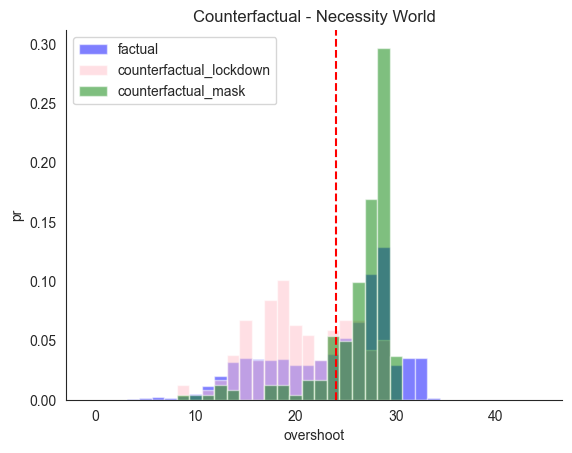

In [29]:
width = 45/36
plt.bar(
    bin_edges[:36].tolist(),
    hist_fact_nec,
    align="center",
    width=width,
    alpha=0.5,
    color="blue",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_lockdown_nec,
    align="center",
    width=width,
    alpha=0.5,
    color="pink",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_mask_nec,
    align="center",
    width=width,
    alpha=0.5,
    color="green",
)
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual - Necessity World")
plt.axvline(x=(overshoot_threshold), color = "red", linestyle = "--", label="overshoot too high")
sns.despine()

print("Overshoot mean")
print(
    "factual: ",
    os_fact_nec.item(),
    " counterfactual mask: ",
    os_mask_nec.item(),
    " counterfactual lockdown: ",
    os_lockdown_nec.item(),
)

print("Probability of overshoot being high")
print(
    "factual: ",
    oth_fact_nec.item(),
    " counterfactual mask: ",
    oth_mask_nec.item(),
    " counterfactual lockdown: ",
    oth_lockdown_nec.item(),
)

The above histogram also takes into account the context that is being kept fixed. If `lockdown` is being intervened on, keeping `lockdown_efficiency` fixed would hinder the effect of intervention. Thus to obtain the relevant samples, we also filter for the appropriate context. Once we have filtered for the context, we take the samples and plot them as density above. The histogram above plots three quantities. It plots $P(\mathit{os} | \mathit{ld}, m)$ as the factual distribution of overshoot, $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{ld}'} | \mathit{ld}, m)$ as `counterfactual_lockdown` where $W = \{\mathit{me}\}$ and $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{m}'} | \mathit{ld}, m)$ as `counterfactual_mask` where $W = \{\mathit{le}\}$. These distributions help in comparing how necessity interventions for the two antecedents affect the overshoot.

We can have similar plots for sufficiency worlds (indicated by 2) where variables are intervened on to have their antecedent values. While this might seem redundant, this investigates probabilistically the impact of the implemented interventons: after all, it might be the case that the observed outcome is an unusual one and that usually those interventions do not lead to the outcome of interest. The resulting plots show that when `mask` is set to be 1, there is a higher probability of high overshoot, but that this distribution is more flat than the distribution for `lockdown` being set to 1, which has higher peaks.

In [30]:
hist_fact_suff, bin_edges, os_fact_suff, oth_fact_suff = histogram_data(
    importance_tr, mwc_imp, {}, 0
)
hist_mask_suff, bin_edges, os_mask_suff, oth_mask_suff = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 0,
        "__cause____antecedent_lockdown": 1,
        "__cause____witness_mask_efficiency": 0,
        "lockdown": 1, "mask": 1
    },
    2,
)
hist_lockdown_suff, bin_edges, os_lockdown_suff, oth_lockdown_suff = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 1,
        "__cause____antecedent_lockdown": 0,
        "__cause____witness_lockdown_efficiency": 0,
        "lockdown": 1, "mask": 1
    },
    2,
)

Overshoot mean
factual:  24.31097984313965  counterfactual mask:  27.37161636352539  counterfactual lockdown:  26.888933181762695
Probability of overshoot being high
factual:  0.6075999736785889  counterfactual mask:  0.7061855792999268  counterfactual lockdown:  0.7263157963752747


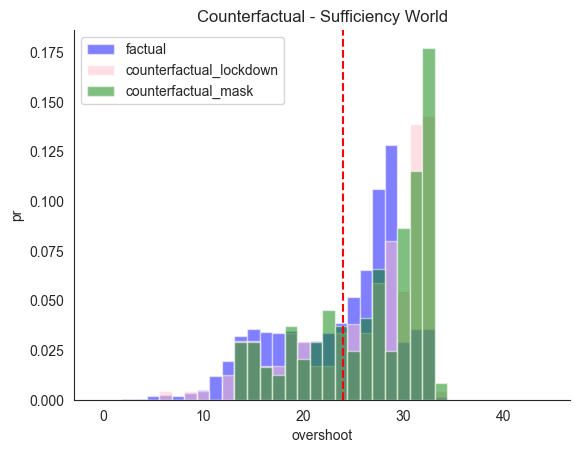

In [31]:
width = 45/36
plt.bar(
    bin_edges[:36].tolist(),
    hist_fact_suff,
    align="center",
    width=width,
    alpha=0.5,
    color="blue",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_lockdown_suff,
    align="center",
    width=width,
    alpha=0.5,
    color="pink",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_mask_suff,
    align="center",
    width=width,
    alpha=0.5,
    color="green",
)
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual - Sufficiency World")
plt.axvline(x=(overshoot_threshold), color = "red", linestyle = "--", label="overshoot too high")
sns.despine()

print("Overshoot mean")
print(
    "factual: ",
    os_fact_suff.item(),
    " counterfactual mask: ",
    os_mask_suff.item(),
    " counterfactual lockdown: ",
    os_lockdown_suff.item(),
)

print("Probability of overshoot being high")
print(
    "factual: ",
    oth_fact_suff.item(),
    " counterfactual mask: ",
    oth_mask_suff.item(),
    " counterfactual lockdown: ",
    oth_lockdown_suff.item(),
)

The histogram plots three quantities. It plots $P(\mathit{os} | \mathit{ld}, m)$ as the factual distribution of overshoot, $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{ld}} | \mathit{ld}, m)$ as `counterfactual_lockdown` where $W = \{\mathit{me}\}$ and $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{m}} | \mathit{ld}, m)$ as `counterfactual_mask` where $W = \{\mathit{le}\}$. Again, these distributions help in comparing how sufficiency interventions for the two antecedents affect the overshoot.

We can also combine samples from both sufficiency and necessity worlds to focus on a context-sensitive counterpart of the joint probability of necessity and sufficiency directly (see the previous tutorial for more explanation). We first visualize samples where only lockdown is considered as an intervention. Then we analyze masking as an intervention.

In [32]:
# Collecting samples for joint distribution of overshoot under necessity and sufficiency interventions on lockdown
masks = {
        "__cause____antecedent_mask": 1,
        "__cause____antecedent_lockdown": 0,    # Intervening only on lockdown
        "__cause____witness_lockdown_efficiency": 0, # Excluding lockdown efficiency fron the context candidates
        "lockdown": 1, "mask": 1 # Conditioning on lockdown and masking being imposed in factual world
    }
with mwc_imp:
    data_nec = gather(
        importance_tr.nodes["overshoot"]["value"],
        IndexSet(**{"lockdown": {1}, "mask": {1}}),
    )

    data_suff = gather(
        importance_tr.nodes["overshoot"]["value"],
        IndexSet(**{"lockdown": {2}, "mask": {2}}),
    )


    mask_tensor = torch.ones(
        importance_tr.nodes["__cause____antecedent_mask"]["value"].shape
    ).bool()
    for key, val in masks.items():
        mask_tensor = mask_tensor & (importance_tr.nodes[key]["value"] == val)

    data_suff = data_suff.squeeze()[torch.nonzero(mask_tensor.squeeze())]
    data_nec = data_nec.squeeze()[torch.nonzero(mask_tensor.squeeze())]

a = torch.transpose(torch.vstack((data_nec.squeeze(), data_suff.squeeze())), 0, 1) # Joint distribution
hist_lockdown_2d, rough = torch.histogramdd(a, bins=[36, 36], density=True, range=[0.0, 45.0, 0.0, 45.0])
pr_lockdown = (hist_lockdown_2d[:16, 16:].sum()/hist_lockdown_2d.sum())


# Collecting samples for joint distribution of overshoot under necessity and sufficiency interventions on mask
masks = {
        "__cause____antecedent_mask": 0,
        "__cause____antecedent_lockdown": 1,    # Intervening only on mask
        "__cause____witness_mask_efficiency": 0,    # Excluding mask efficiency fron the context candidates
        "lockdown": 1, "mask": 1    # Conditioning on lockdown and masking being imposed in factual world
    }
with mwc_imp:
    data_nec = gather(
        importance_tr.nodes["overshoot"]["value"],
        IndexSet(**{"lockdown": {1}, "mask": {1}}),
    )

    data_suff = gather(
        importance_tr.nodes["overshoot"]["value"],
        IndexSet(**{"lockdown": {2}, "mask": {2}}),
    )

    mask_tensor = torch.ones(
        importance_tr.nodes["__cause____antecedent_mask"]["value"].shape
    ).bool()
    for key, val in masks.items():
        mask_tensor = mask_tensor & (importance_tr.nodes[key]["value"] == val)

    data_suff = data_suff.squeeze()[torch.nonzero(mask_tensor.squeeze())]
    data_nec = data_nec.squeeze()[torch.nonzero(mask_tensor.squeeze())]

a = torch.transpose(torch.vstack((data_nec.squeeze(), data_suff.squeeze())), 0, 1) # Joint distribution
hist_mask_2d, _ = torch.histogramdd(a, bins = [36, 36], density=True, range=[0.0, 45.0, 0.0, 45.0])
pr_mask = (hist_mask_2d[:16, 16:].sum()/hist_mask_2d.sum())

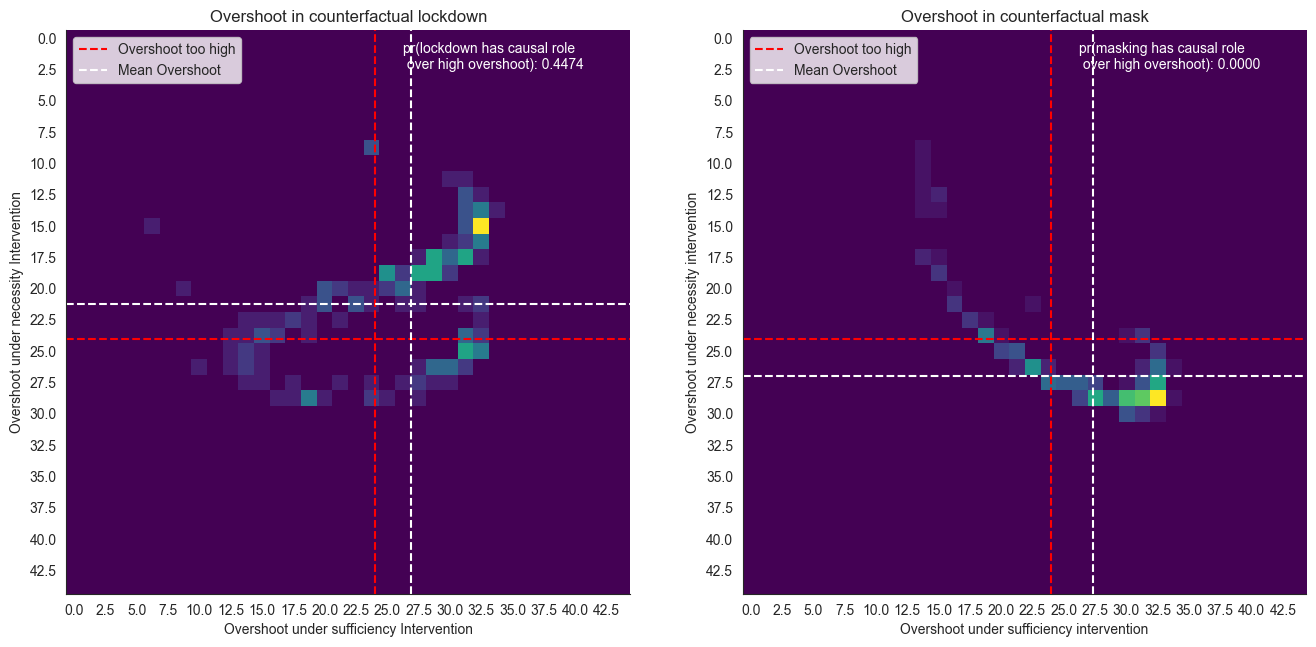

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax = axs[0]
hist_lockdown = hist_lockdown_nec.unsqueeze(1) * hist_lockdown_suff.unsqueeze(0)
ax.imshow(hist_lockdown_2d, cmap="viridis")
ax.set(xticks=range(0, 36, 2), xticklabels=bin_edges[0:36:2].tolist())
ax.set(yticks=range(0, 36, 2), yticklabels=bin_edges[0:36:2].tolist())
ax.set(
    xlabel="Overshoot under sufficiency Intervention",
    ylabel="Overshoot under necessity Intervention",
    title="Overshoot in counterfactual lockdown",
)
ax.axvline(x=(overshoot_threshold) * 36 / 45, color="red", linestyle="--", label="Overshoot too high")
ax.axhline(y=(overshoot_threshold) * 36 / 45, color="red", linestyle="--")

ax.axvline(
    x=(os_lockdown_suff) * 36 / 45,
    color="white",
    linestyle="--",
    label="Mean Overshoot",
)
ax.axhline(y=(os_lockdown_nec) * 36 / 45, color="white", linestyle="--")

ax.legend(loc="upper left")
ax.text(21, 2, 'pr(lockdown has causal role \n over high overshoot): %.4f' % pr_lockdown.item(), color="white")

ax = axs[1]
hist_mask = hist_mask_nec.unsqueeze(1) * hist_mask_suff.unsqueeze(0)
ax.imshow(hist_mask_2d, cmap="viridis")
ax.set(xticks=range(0, 36, 2), xticklabels=bin_edges[0:36:2].tolist())
ax.set(yticks=range(0, 36, 2), yticklabels=bin_edges[0:36:2].tolist())
ax.set(
    xlabel="Overshoot under sufficiency intervention",
    ylabel="Overshoot under necessity intervention",
    title="Overshoot in counterfactual mask",
)
ax.axvline(x=(overshoot_threshold) * 36 / 45, color="red", linestyle="--", label="Overshoot too high")
ax.axhline(y=(overshoot_threshold) * 36 / 45, color="red", linestyle="--")

ax.axvline(
    x=(os_mask_suff) * 36 / 45,
    color="white",
    linestyle="--",
    label="Mean Overshoot",
)
ax.axhline(y=(os_mask_nec) * 36 / 45, color="white", linestyle="--")
ax.text(21, 2, 'pr(masking has causal role \n over high overshoot): %.4f' % pr_mask.item(), color="white")

ax.legend(loc="upper left")

sns.despine()

The above heatmaps plot the joint distributions arising from necessity and sufficient interventions, particularly $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{ld}}, \mathit{os}^w_{\mathit{ld}'}|\mathit{ld, m})$ where $W = \{\mathit{me}\}$ and $\sum_{w \subseteq W} P_w(w) \cdot P(\mathit{os}^w_{\mathit{m}}, \mathit{os}^w_{\mathit{m}'}|\mathit{ld, m})$ where $W = \{\mathit{le}\}$.

It is evident from the plot above that counterfactual for lockdown has more probability mass in the top right quadrant (low overshoot in the necessity world and high overshoot in the sufficient world). This gives us a more clear picture into why lockdown has more causal role in overshoot being too high as compared to masking.

## Looking into different contexts for curious readers

`SearchForExplanation` allows the users to perform an even finer grained analysis by visualizing distributions of random variables when different contexts are kept fixed in the model. To illustrate this, we consider the following two scenarios:
1. Intervene on `lockdown=1` while keeping `mask_efficiency` fixed (or not).
2. Intervene on `mask=1` while keeping `lockdown_efficiency` fixed (or not).

The key motivation for looking into this is the intuition that there is some part of the actual context in which removing lockdown would significantly lower the overshoot, whereas there is no corresponding part of the actual context in which removing masking would lead to lower overshoot - which is the core of the assymetricity between the two intervetnions in our example.

We first intervene on `lockdown` being 1 and analyze how the distribution of `overshoot` change as we keep the `mask_efficiency` fixed (or not).

In [34]:
hist_lockdown_fix, bin_edges, os_lockdown_fix, oth_lockdown_fix = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 1,
        "__cause____antecedent_lockdown": 0,
        "__cause____witness_lockdown_efficiency": 0,
        "__cause____witness_mask_efficiency": 1,
        "lockdown": 1, "mask": 1
    },
    1,
)
hist_lockdown_notfix, bin_edges, os_lockdown_notfix, oth_lockdown_notfix = (
    histogram_data(
        importance_tr,
        mwc_imp,
        {
            "__cause____antecedent_mask": 1,
            "__cause____antecedent_lockdown": 0,
            "__cause____witness_lockdown_efficiency": 0,
            "__cause____witness_mask_efficiency": 0,
            "lockdown": 1, "mask": 1
        },
        1,
    )
)

Overshoot mean
mask_efficiency fixed:  18.844215393066406  mask_efficiency not fixed:  26.454023361206055
Probability of overshoot being high
mask_efficiency fixed:  0.10000000149011612  mask_efficiency not fixed:  0.8999999761581421


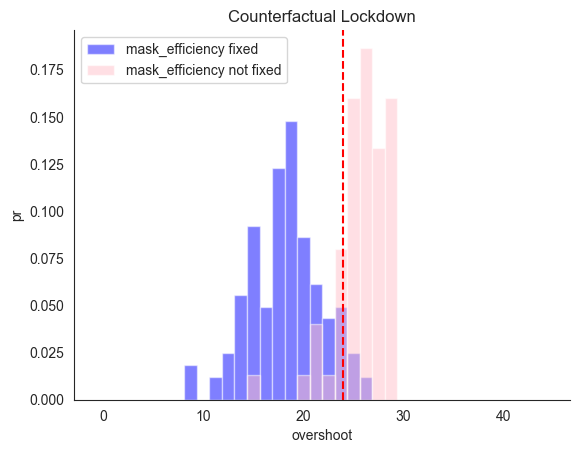

In [35]:
width = 45/36
plt.bar(
    bin_edges[:36].tolist(),
    hist_lockdown_fix,
    align="center",
    width=width,
    alpha=0.5,
    color="blue",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_lockdown_notfix,
    align="center",
    width=width,
    alpha=0.5,
    color="pink",
)
plt.legend(["mask_efficiency fixed", "mask_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual Lockdown")
plt.axvline(x=(overshoot_threshold), color = "red", linestyle = "--", label="overshoot too high")
sns.despine()

print("Overshoot mean")
print(
    "mask_efficiency fixed: ",
    os_lockdown_fix.item(),
    " mask_efficiency not fixed: ",
    os_lockdown_notfix.item(),
)

print("Probability of overshoot being high")
print(
    "mask_efficiency fixed: ",
    oth_lockdown_fix.item(),
    " mask_efficiency not fixed: ",
    oth_lockdown_notfix.item(),
)

We use the notation $\mathit{os}^m$ to describe the variable $\mathit{os}$ when $m$ is kept fixed. 

The above histogram plots the following distributions:
1. `mask_efficiency fixed`: $P( \mathit{os}^{\mathit{me}}_{\mathit{ld}'} | \mathit{ld}, m)$
2. `mask_efficiency not fixed`: $P( \mathit{os}_{\mathit{ld}'} | \mathit{ld}, m)$

The plot clearly shows that depending on the fact that `mask_efficiency` was kept fixed on the factual value or not, the `overshoot` variable changes. Crucially, if we keep the mask efficiency at the actual value, the probability of the overshoot being too high drops down to $\approx 0.08$.

We then run an analogous analysis for masking - we intervene on `mask` being 1 and analyze how the distribution of `overshoot` change as we keep the `lockdown_efficiency` fixed or not.

In [36]:
hist_mask_fix, bin_edges, os_mask_fix, oth_mask_fix = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 0,
        "__cause____antecedent_lockdown": 1,
        "__cause____witness_mask_efficiency": 0,
        "__cause____witness_lockdown_efficiency": 1,
        "lockdown": 1, "mask": 1
    },
    1,
)
hist_mask_notfix, bin_edges, os_mask_notfix, oth_mask_notfix = histogram_data(
    importance_tr,
    mwc_imp,
    {
        "__cause____antecedent_mask": 0,
        "__cause____antecedent_lockdown": 1,
        "__cause____witness_mask_efficiency": 0,
        "__cause____witness_lockdown_efficiency": 0,
        "lockdown": 1, "mask": 1
    },
    1,
)

Overshoot mean
lockdown_efficiency fixed:  27.033872604370117  lockdown_efficiency not fixed:  26.814355850219727
Probability of overshoot being high
lockdown_efficiency fixed:  0.8768116235733032  lockdown_efficiency not fixed:  0.8928571343421936


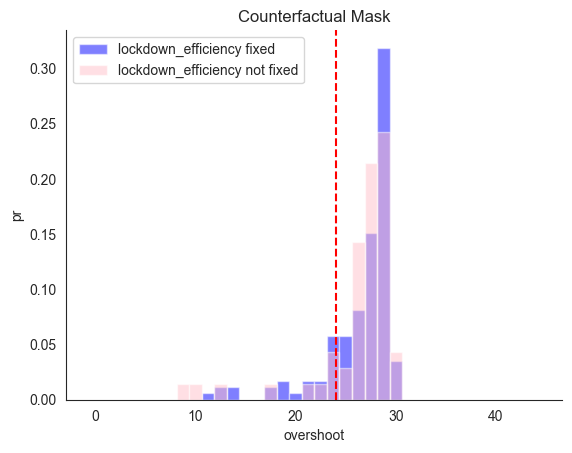

In [46]:
width = 45/36
plt.bar(
    bin_edges[:36].tolist(),
    hist_mask_fix,
    align="center",
    width=width,
    alpha=0.5,
    color="blue",
)
plt.bar(
    bin_edges[:36].tolist(),
    hist_mask_notfix,
    align="center",
    width=width,
    alpha=0.5,
    color="pink",
)
plt.legend(["lockdown_efficiency fixed", "lockdown_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual Mask")
plt.axvline(x=(overshoot_threshold), color = "red", linestyle = "--", label="overshoot too high")
sns.despine()

print("Overshoot mean")
print(
    "lockdown_efficiency fixed: ",
    os_mask_fix.item(),
    " lockdown_efficiency not fixed: ",
    os_mask_notfix.item(),
)

print("Probability of overshoot being high")
print(
    "lockdown_efficiency fixed: ",
    oth_mask_fix.item(),
    " lockdown_efficiency not fixed: ",
    oth_mask_notfix.item(),
)

Similarly to the earlier histogram, the above plot shows the following distributions:
1. `lockdown_efficiency fixed`: $P( \mathit{os}^{\mathit{le}}_{\mathit{m}'} | \mathit{ld}, m)$
2. `lockdown_efficiency not fixed`: $P( \mathit{os}_{\mathit{m}'} | \mathit{ld}, m)$

The plot clearly shows that `lockdown_efficiency` as a context has little effect on how intervening on `mask` affects `overshoot`. Again, crucially, whichever context setting we choose here, withdrawing the masking policy does not radically change the fact that the overshoot is still very likely to be too high.